Drive化にデータを置くと処理が遅くなるため、content下に移動

In [3]:
!cp -r /content/drive/MyDrive/data_splits /content/

In [4]:
import os, shutil, random
from pathlib import Path


#データセットフォルダ
dst_root = Path("/content/data_splits")
train_root = Path(dst_root, "train")
val_root   = Path(dst_root, "val")

破損しているデータがないかを確認し、必要に応じて破損データを削除する

In [18]:
from PIL import Image, UnidentifiedImageError

def check_images(root):
    total = ok = empty = corrupted = 0
    for p in root.rglob("*.*"):
        if p.is_file():
            total += 1
            try:
                if p.stat().st_size == 0:  # サイズ0バイト
                    empty += 1
                else:
                    with Image.open(p) as img:
                        img.verify()  # 壊れていないか検証
                    ok += 1
            except (UnidentifiedImageError, OSError):
                corrupted += 1
    print(f"=== {root} ===")
    print(f"Total     : {total}")
    print(f"OK        : {ok}")
    print(f"Empty     : {empty}")
    print(f"Corrupted : {corrupted}")
    return total, ok, empty, corrupted

train_stats = check_images(train_root)
val_stats   = check_images(val_root)

print("\n=== Summary ===")
print(f"Train: {train_stats}")
print(f"Val  : {val_stats}")


=== /content/data_splits/train ===
Total     : 1079
OK        : 1079
Empty     : 0
Corrupted : 0
=== /content/data_splits/val ===
Total     : 270
OK        : 270
Empty     : 0
Corrupted : 0

=== Summary ===
Train: (1079, 1079, 0, 0)
Val  : (270, 270, 0, 0)


In [ ]:

# 必要に応じて削除したい画像のパスを指定
bad_file = Path("")

if bad_file.exists():
    bad_file.unlink()  # 削除
    print("Deleted:", bad_file)
else:
    print("Not found:", bad_file)


IsADirectoryError: [Errno 21] Is a directory: '.'

データ拡張とデータセットの設定

データ拡張の説明

*   transforms.Lambda(lambda im: im.convert("RGB"))
→ 画像を強制的に RGB 化（チャンネル数を揃えるために必須）

*   transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), interpolation=InterpolationMode.BICUBIC)
→ 画像のランダムな部分を切り出してリサイズ
→ ズームイン・位置の違いに強いモデルを作る

*   transforms.RandomHorizontalFlip(p=0.5)
→ 50% の確率で左右反転
→ 左右対称な対象ならデータ量を実質2倍に増やせる

*   transforms.RandomApply([transforms.ColorJitter(...)], p=0.5)
→ 50% の確率で明るさ・コントラスト・彩度・色相をランダムに変更
→ 照明や色味の変化にロバストになる

*   transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1)
→ 10% の確率でガウシアンぼかし
→ 撮影時のピントずれや軽いブレに耐性を持たせる

*   transforms.ToTensor()
→ 画像を PyTorch のテンソル形式 [C,H,W] に変換

*   transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
→ ImageNet の平均・標準偏差で正規化
→ 事前学習済みモデル（ResNet, ViTなど）に合わせるため必須

*   transforms.RandomErasing(p=0.25, scale=(0.02,0.08), ratio=(0.3,3.3))
→ 25% の確率で画像の一部を矩形で塗りつぶす
→ 欠損や汚れがあっても識別できるようにする


In [35]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode

IMAGENET_MEAN=(0.485,0.456,0.406); IMAGENET_STD=(0.229,0.224,0.225)
IMG_SIZE=224

train_tfms = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("RGB")),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0),
                                 interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),  # 部品の左右対称が前提。NGなら外す
    transforms.RandomApply([transforms.ColorJitter(0.15,0.15,0.15,0.02)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),  # ぼかし弱
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.25, scale=(0.02,0.08), ratio=(0.3,3.3)),   # 小さめの欠損
])

val_tfms = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("RGB")),
    transforms.Resize(int(IMG_SIZE*1.15), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [36]:
from torch.utils.data import DataLoader
import torch
from torchvision import datasets

train_ds = datasets.ImageFolder(str(train_root), transform=train_tfms)
val_ds   = datasets.ImageFolder(str(val_root),   transform=val_tfms)


train_loader = DataLoader(train_ds, batch_size=32,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)


モデルと損失関数、最適化関数の定義

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# GPU を使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Resnet
model = models.resnet18(pretrained=True)
# 出力を2クラス用に置き換え
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(device)


# 損失関数 & optimizer設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
import numpy as np
import cv2
import torch

epochs = 50  # 最大エポック数
best_val_acc = 0.0
val_loss_his = []
ckpt_path = "/content/best_model_Resnet18.pt" # 重みファイルの保存先

patience = 2   # 何エポック改善がなければ止めるか
no_improve = 0 # 改善がないエポック数カウンタ



def evaluate(model, loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss_sum += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return loss_sum / total, correct / total

for epoch in range(1, epochs + 1):
    model.train()
    run_loss, run_correct, run_total = 0.0, 0, 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        run_loss += loss.item() * imgs.size(0)
        run_correct += (logits.argmax(dim=1) == labels).sum().item()
        run_total += labels.size(0)

    train_loss = run_loss / run_total
    train_acc  = run_correct / run_total
    val_loss, val_acc = evaluate(model, val_loader)
    val_loss_his.append(val_loss)

    print(f"[Epoch {epoch:02d}] "
          f"train_loss={train_loss:.4f}  train_acc={train_acc*100:.2f}%  "
          f"val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%")

    scheduler.step(val_acc)

    # ベスト更新時だけ保存
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), ckpt_path)
        print(f" Best updated (val_loss={val_loss:.4f}) -> {ckpt_path}")

    if epoch > 1 and val_loss_his[epoch-1] > val_loss_his[epoch-2]:
          no_improve += 1
    else:
          no_improve = 0

    # Early stopping
    if no_improve >= patience:
        print("⏹ Early stopping triggered.")
        break

print(f"Done. Best val_acc = {best_val_acc:.4f}")


[Epoch 01] train_loss=0.3270  train_acc=85.73%  val_loss=0.1653  val_acc=93.70%
 Best updated (val_loss=0.1653) -> /content/best_model_Resnet50.pt
[Epoch 02] train_loss=0.1440  train_acc=94.35%  val_loss=0.1116  val_acc=96.67%
 Best updated (val_loss=0.1116) -> /content/best_model_Resnet50.pt
[Epoch 03] train_loss=0.1405  train_acc=94.90%  val_loss=0.1429  val_acc=92.96%
[Epoch 04] train_loss=0.0754  train_acc=97.41%  val_loss=0.0698  val_acc=97.41%
 Best updated (val_loss=0.0698) -> /content/best_model_Resnet50.pt
[Epoch 05] train_loss=0.0670  train_acc=97.50%  val_loss=0.0693  val_acc=97.04%
[Epoch 06] train_loss=0.0712  train_acc=97.03%  val_loss=0.0533  val_acc=97.04%
[Epoch 07] train_loss=0.0661  train_acc=97.50%  val_loss=0.0689  val_acc=98.15%
 Best updated (val_loss=0.0689) -> /content/best_model_Resnet50.pt
[Epoch 08] train_loss=0.0670  train_acc=97.41%  val_loss=0.0181  val_acc=99.63%
 Best updated (val_loss=0.0181) -> /content/best_model_Resnet50.pt
[Epoch 09] train_loss=0.0

結果指標を算出

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=== 運用点(Recall=100%を満たす閾値) ===
閾値 τ*                  : 0.023616
Recall@τ* (期待=1.0)     : 1.0000
Precision@Recall=100%    : 0.8140

=== 一枚当たりの推論時間 ===
p50=0.14 ms, p95=0.28 ms


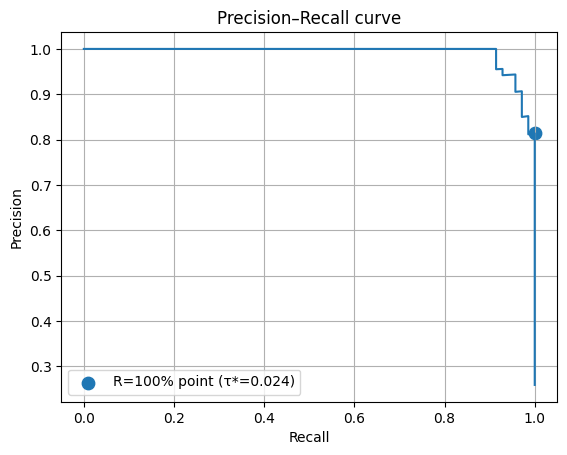

In [66]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import precision_recall_curve, average_precision_score

weight_path = "/content/best_model_Resnet18.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 学習時と同様にモデルを定義
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
state = torch.load(weight_path, map_location=device)
model.load_state_dict(state)
model.to(device).eval()

all_probs, all_labels, per_image_latencies = [], [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device, non_blocking=True)

        # GPU計測の前後で同期
        if device.type == "cuda":
            torch.cuda.synchronize()
        t0 = time.perf_counter()

        logits = model(imgs)                  # [B, C]

        if device.type == "cuda":
            torch.cuda.synchronize()
        t1 = time.perf_counter()

        batch_time = t1 - t0
        per_image_latencies.extend([batch_time / imgs.size(0)] * imgs.size(0))

        probs = torch.softmax(logits, dim=1)  # [B, C]
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

probs = np.concatenate(all_probs, axis=0)  # [N, C]
y     = np.concatenate(all_labels, axis=0) # [N]

# class_to_idx: {'bad': 0, 'good': 1}
POSITIVE_LABEL = 0         # bad のラベルID
POSITIVE_IDX   = 0         # bad の確率列
y_true_bin = (y == POSITIVE_LABEL).astype(int)        # [N] 0/1
y_score    = probs[:, POSITIVE_IDX].astype(float)     # [N]

# PR / AP
precision, recall, thr = precision_recall_curve(y_true_bin, y_score)
ap = average_precision_score(y_true_bin, y_score)

# Recall=100%を満たす運用閾値 τ* と P@R=100%
pos_scores = y_score[y_true_bin == 1]
if len(pos_scores) == 0:
    raise ValueError("不良（陽性）が1つもないため評価できません。")

tau_star = float(pos_scores.min())                 # 閾値：不良の最小スコア
y_pred_op = (y_score >= tau_star).astype(int)      # 1=不良で予測

TP = int(((y_pred_op == 1) & (y_true_bin == 1)).sum())
FP = int(((y_pred_op == 1) & (y_true_bin == 0)).sum())
TN = int(((y_pred_op == 0) & (y_true_bin == 0)).sum())
FN = int(((y_pred_op == 0) & (y_true_bin == 1)).sum())

recall_at_tau    = TP / (TP + FN) if (TP + FN) else 0.0
precision_at_tau = TP / (TP + FP) if (TP + FP) else 0.0

# レイテンシ統計
lat_ms = np.array(per_image_latencies) * 1000.0
p50 = np.percentile(lat_ms, 50)
p95 = np.percentile(lat_ms, 95)

print("=== 運用点(Recall=100%を満たす閾値) ===")
print(f"閾値 τ*                  : {tau_star:.6f}")
print(f"Recall@τ* (期待=1.0)     : {recall_at_tau:.4f}")
print(f"Precision@Recall=100%    : {precision_at_tau:.4f}")
print("\n=== 一枚当たりの推論時間 ===")
print(f"p50={p50:.2f} ms, p95={p95:.2f} ms")

# PRカーブ表示
plt.figure()
plt.plot(recall, precision, )
plt.scatter([1.0], [precision_at_tau], s=80, marker='o',
            label=f'R=100% point (τ*={tau_star:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall curve')
plt.grid(True); plt.legend(); plt.show()
